# Predict Churn on "Telecom Churn Case Study Hackathon" Dataset

Predict churning customers for a Telecom company based on temporal behaviour of 3 months. Model using Random Forest, XGB, Catboost, LGBM model as base model then combine  with Stacking Classifier and Voting Classifier. Hypermarameter tuning using optuna.

Best model is Voting Classifier with 94.019% accuracy.

In [2]:
# Import libraries and setup
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/telecom-churn/data_dictionary.csv
/kaggle/input/telecom-churn/sample.csv
/kaggle/input/telecom-churn/starter-notebook - Labs 1.ipynb
/kaggle/input/telecom-churn/train.csv
/kaggle/input/telecom-churn/test.csv


In [3]:
#Import dataset and combine the train and test for cleaning part
train = pd.read_csv('/kaggle/input/telecom-churn/train.csv')
test = pd.read_csv('/kaggle/input/telecom-churn/test.csv')
df = pd.concat([test.assign(ind="test"), train.assign(ind="train")])
df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,ind,churn_probability
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,NaN,NaN,NaN,1692,0.00,0.00,0.00,test,NaN
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,NaN,NaN,NaN,2533,0.00,0.00,0.00,test,NaN
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,NaN,NaN,NaN,277,525.61,758.41,241.84,test,NaN
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,NaN,NaN,NaN,1244,0.00,0.00,0.00,test,NaN
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,NaN,NaN,NaN,462,0.00,0.00,0.00,test,NaN


In [4]:
# Check statistics
df.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,99999.000000,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,...,99999.000000,99999.000000,25153.000000,25571.000000,26339.000000,99999.000000,99999.000000,99999.000000,99999.000000,69999.000000
mean,49999.000000,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,132.395875,133.670805,...,0.080401,0.084501,0.914404,0.908764,0.890808,1219.854749,68.170248,66.839062,60.021204,0.101887
std,28867.369122,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,297.207406,308.794148,...,0.628334,0.660234,0.279772,0.287950,0.311885,954.733842,267.580450,271.201856,253.938223,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,24999.500000,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,7.380000,6.660000,...,0.000000,0.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000
50%,49999.000000,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,34.310000,32.330000,...,0.000000,0.000000,1.000000,1.000000,1.000000,863.000000,0.000000,0.000000,0.000000,0.000000
75%,74998.500000,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,118.740000,115.595000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1807.500000,0.000000,0.000000,0.000000,0.000000
max,99998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,35.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.210000,1.000000


COLUMN DESC FROM DATASET:

*.6   =   KPI for the month of June  
*.7   =   KPI for the month of July  
*.8   =   KPI for the month of August  
2G   =   G network  
3G   =   G network  
AMT   =   Amount in local currency  
AON   =   Age on network  number of days the customer is using the operator T network  
ARPU   =   Average revenue per user  
AV   =   Average  
CIRCLE_ID   =   Telecom circle area to which the customer belongs to  
DATA   =   Mobile internet  
FB_USER   =   Service scheme to avail services of Facebook and similar social networking sites  
IC   =   Incoming calls  
ISD   =   ISD calls  
LOC   =   Local calls  within same telecom circle  
MAX   =   Maximum  
MONTHLY   =   Service schemes with validity equivalent to a month  
MOU   =   Minutes of usage  voice calls  
NIGHT   =   Scheme to use during specific night hours only  
NUM   =   Number  
OFFNET   =   All kind of calls outside the operator T network  
OG   =   Outgoing calls  
ONNET   =   All kind of calls within the same operator network  
PCK   =   Prepaid service schemes called  PACKS  
RECH   =   Recharge  
ROAM   =   Indicates that customer is in roaming zone during the call  
SACHET   =   Service schemes with validity smaller than a month  
SPL   =   Special calls  
STD   =   STD calls  outside the calling circle  
T2C   =   Operator T to its own call center  
T2F   =   Operator T to fixed lines of T  
T2M   =   Operator T to other operator mobile  
T2O   =   Operator T to other operator fixed line  
T2T   =   Operator T to T ie within same operator mobile to mobile  
VBC   =   Volume based cost  when no specific scheme is not purchased and paid as per usage  
VOL   =   Mobile internet usage volume in MB  

# Data Cleaning

1. UNUSED COLUMN
- id = only display unique id
- circle_id = have same value for every rows

2. CHECK COLUMN WITH 0 VALUES
- check column with 0 on all rows then drop the column

3. CHECK NA

In [5]:
# Check column with 0 value
df.describe().loc[:, df.describe().loc['mean'] == 0]

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
count,98981.0,98981.0,98981.0,96062.0,96140.0,94621.0,96062.0,96140.0,94621.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Remove 9 column with zero data + 2 unused column
df.drop(columns=['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou',
                 'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',
                 'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8',
                 'id','circle_id'], axis = 1, inplace = True)

print(df.shape,'With 11 columns dropped, left with only 162 columns')

(99999, 162) With 11 columns dropped, left with only 162 columns


In [7]:
# Check NA
df.isna().sum().sort_values(ascending=False)[lambda x: x > 0].to_numpy()

array([74846, 74846, 74846, 74846, 74846, 74846, 74846, 74846, 74846,
       74846, 74428, 74428, 74428, 74428, 74428, 74428, 74428, 74428,
       74428, 74428, 73660, 73660, 73660, 73660, 73660, 73660, 73660,
       73660, 73660, 73660, 30000,  5378,  5378,  5378,  5378,  5378,
        5378,  5378,  5378,  5378,  5378,  5378,  5378,  5378,  5378,
        5378,  5378,  5378,  5378,  5378,  5378,  5378,  5378,  5378,
        5378,  5378,  5378,  5378,  3937,  3937,  3937,  3937,  3937,
        3937,  3937,  3937,  3937,  3937,  3937,  3937,  3937,  3937,
        3937,  3937,  3937,  3937,  3937,  3937,  3937,  3937,  3937,
        3937,  3937,  3937,  3937,  3859,  3859,  3859,  3859,  3859,
        3859,  3859,  3859,  3859,  3859,  3859,  3859,  3859,  3859,
        3859,  3859,  3859,  3859,  3859,  3859,  3859,  3859,  3859,
        3859,  3859,  3859,  3859,  3622,  1767,  1607,  1100,   601])

# Data Feature Engineering

1. CREATE NEW DATA POINT TO CAPTURE DAY DIFFERENCE BETWEEN LAST RECHARGE AND LAST DATE OF MONTH
- Used date_of_last_rech and date_of_last_rech_data column
- Then drop the date column for modelling

2. LINKED 3 MONTH DATA TO CAPTURE TREND
- Add 3 feature for each 52 column monthly trend. Diff from 1st to 2nd, diff 2nd to 3rd and diff 1st to 3rd 

In [8]:
# Transform date column into difference date to last day of month its month, and drop date column after

date_columns = ['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
               'last_date_of_month_6','last_date_of_month_7','last_date_of_month_8']

df[date_columns] = df[date_columns].apply(pd.to_datetime)

df['diff_date_of_last_rech_6'] = (df['last_date_of_month_6'] - df['date_of_last_rech_6']).dt.days 
df['diff_date_of_last_rech_7'] = (df['last_date_of_month_7'] - df['date_of_last_rech_7']).dt.days  
df['diff_date_of_last_rech_8'] = (df['last_date_of_month_8'] - df['date_of_last_rech_8']).dt.days 

df['diff_date_of_last_rech_data_6'] = (df['last_date_of_month_6'] - df['date_of_last_rech_data_6']).dt.days  
df['diff_date_of_last_rech_data_7'] = (df['last_date_of_month_7'] - df['date_of_last_rech_data_7']).dt.days  
df['diff_date_of_last_rech_data_8'] = (df['last_date_of_month_8'] - df['date_of_last_rech_data_8']).dt.days 

df.drop(columns=date_columns,axis=1, inplace = True)
df.shape


(99999, 159)

In [9]:
# Prepare data before transforming
df.rename(columns={'jun_vbc_3g':'vbc_3g_6',
           'jul_vbc_3g':'vbc_3g_7',
           'aug_vbc_3g':'vbc_3g_8'},inplace=True)

df.fillna(0,inplace=True)

In [10]:
%%capture
# Create feature engineering for 52 monthly trend column
df['arpu_67'] = df['arpu_7'] - df['arpu_6']
df['arpu_78'] = df['arpu_8'] - df['arpu_7']
df['arpu_68'] = df['arpu_8'] - df['arpu_6']
df['onnet_mou_67'] = df['onnet_mou_7'] - df['onnet_mou_6']
df['onnet_mou_78'] = df['onnet_mou_8'] - df['onnet_mou_7']
df['onnet_mou_68'] = df['onnet_mou_8'] - df['onnet_mou_6']
df['offnet_mou_67'] = df['offnet_mou_7'] - df['offnet_mou_6']
df['offnet_mou_78'] = df['offnet_mou_8'] - df['offnet_mou_7']
df['offnet_mou_68'] = df['offnet_mou_8'] - df['offnet_mou_6']
df['roam_ic_mou_67'] = df['roam_ic_mou_7'] - df['roam_ic_mou_6']
df['roam_ic_mou_78'] = df['roam_ic_mou_8'] - df['roam_ic_mou_7']
df['roam_ic_mou_68'] = df['roam_ic_mou_8'] - df['roam_ic_mou_6']
df['roam_og_mou_67'] = df['roam_og_mou_7'] - df['roam_og_mou_6']
df['roam_og_mou_78'] = df['roam_og_mou_8'] - df['roam_og_mou_7']
df['roam_og_mou_68'] = df['roam_og_mou_8'] - df['roam_og_mou_6']
df['loc_og_t2t_mou_67'] = df['loc_og_t2t_mou_7'] - df['loc_og_t2t_mou_6']
df['loc_og_t2t_mou_78'] = df['loc_og_t2t_mou_8'] - df['loc_og_t2t_mou_7']
df['loc_og_t2t_mou_68'] = df['loc_og_t2t_mou_8'] - df['loc_og_t2t_mou_6']
df['loc_og_t2m_mou_67'] = df['loc_og_t2m_mou_7'] - df['loc_og_t2m_mou_6']
df['loc_og_t2m_mou_78'] = df['loc_og_t2m_mou_8'] - df['loc_og_t2m_mou_7']
df['loc_og_t2m_mou_68'] = df['loc_og_t2m_mou_8'] - df['loc_og_t2m_mou_6']
df['loc_og_t2f_mou_67'] = df['loc_og_t2f_mou_7'] - df['loc_og_t2f_mou_6']
df['loc_og_t2f_mou_78'] = df['loc_og_t2f_mou_8'] - df['loc_og_t2f_mou_7']
df['loc_og_t2f_mou_68'] = df['loc_og_t2f_mou_8'] - df['loc_og_t2f_mou_6']
df['loc_og_t2c_mou_67'] = df['loc_og_t2c_mou_7'] - df['loc_og_t2c_mou_6']
df['loc_og_t2c_mou_78'] = df['loc_og_t2c_mou_8'] - df['loc_og_t2c_mou_7']
df['loc_og_t2c_mou_68'] = df['loc_og_t2c_mou_8'] - df['loc_og_t2c_mou_6']
df['loc_og_mou_67'] = df['loc_og_mou_7'] - df['loc_og_mou_6']
df['loc_og_mou_78'] = df['loc_og_mou_8'] - df['loc_og_mou_7']
df['loc_og_mou_68'] = df['loc_og_mou_8'] - df['loc_og_mou_6']
df['std_og_t2t_mou_67'] = df['std_og_t2t_mou_7'] - df['std_og_t2t_mou_6']
df['std_og_t2t_mou_78'] = df['std_og_t2t_mou_8'] - df['std_og_t2t_mou_7']
df['std_og_t2t_mou_68'] = df['std_og_t2t_mou_8'] - df['std_og_t2t_mou_6']
df['std_og_t2m_mou_67'] = df['std_og_t2m_mou_7'] - df['std_og_t2m_mou_6']
df['std_og_t2m_mou_78'] = df['std_og_t2m_mou_8'] - df['std_og_t2m_mou_7']
df['std_og_t2m_mou_68'] = df['std_og_t2m_mou_8'] - df['std_og_t2m_mou_6']
df['std_og_t2f_mou_67'] = df['std_og_t2f_mou_7'] - df['std_og_t2f_mou_6']
df['std_og_t2f_mou_78'] = df['std_og_t2f_mou_8'] - df['std_og_t2f_mou_7']
df['std_og_t2f_mou_68'] = df['std_og_t2f_mou_8'] - df['std_og_t2f_mou_6']
df['std_og_mou_67'] = df['std_og_mou_7'] - df['std_og_mou_6']
df['std_og_mou_78'] = df['std_og_mou_8'] - df['std_og_mou_7']
df['std_og_mou_68'] = df['std_og_mou_8'] - df['std_og_mou_6']
df['isd_og_mou_67'] = df['isd_og_mou_7'] - df['isd_og_mou_6']
df['isd_og_mou_78'] = df['isd_og_mou_8'] - df['isd_og_mou_7']
df['isd_og_mou_68'] = df['isd_og_mou_8'] - df['isd_og_mou_6']
df['spl_og_mou_67'] = df['spl_og_mou_7'] - df['spl_og_mou_6']
df['spl_og_mou_78'] = df['spl_og_mou_8'] - df['spl_og_mou_7']
df['spl_og_mou_68'] = df['spl_og_mou_8'] - df['spl_og_mou_6']
df['og_others_67'] = df['og_others_7'] - df['og_others_6']
df['og_others_78'] = df['og_others_8'] - df['og_others_7']
df['og_others_68'] = df['og_others_8'] - df['og_others_6']
df['total_og_mou_67'] = df['total_og_mou_7'] - df['total_og_mou_6']
df['total_og_mou_78'] = df['total_og_mou_8'] - df['total_og_mou_7']
df['total_og_mou_68'] = df['total_og_mou_8'] - df['total_og_mou_6']
df['loc_ic_t2t_mou_67'] = df['loc_ic_t2t_mou_7'] - df['loc_ic_t2t_mou_6']
df['loc_ic_t2t_mou_78'] = df['loc_ic_t2t_mou_8'] - df['loc_ic_t2t_mou_7']
df['loc_ic_t2t_mou_68'] = df['loc_ic_t2t_mou_8'] - df['loc_ic_t2t_mou_6']
df['loc_ic_t2m_mou_67'] = df['loc_ic_t2m_mou_7'] - df['loc_ic_t2m_mou_6']
df['loc_ic_t2m_mou_78'] = df['loc_ic_t2m_mou_8'] - df['loc_ic_t2m_mou_7']
df['loc_ic_t2m_mou_68'] = df['loc_ic_t2m_mou_8'] - df['loc_ic_t2m_mou_6']
df['loc_ic_t2f_mou_67'] = df['loc_ic_t2f_mou_7'] - df['loc_ic_t2f_mou_6']
df['loc_ic_t2f_mou_78'] = df['loc_ic_t2f_mou_8'] - df['loc_ic_t2f_mou_7']
df['loc_ic_t2f_mou_68'] = df['loc_ic_t2f_mou_8'] - df['loc_ic_t2f_mou_6']
df['loc_ic_mou_67'] = df['loc_ic_mou_7'] - df['loc_ic_mou_6']
df['loc_ic_mou_78'] = df['loc_ic_mou_8'] - df['loc_ic_mou_7']
df['loc_ic_mou_68'] = df['loc_ic_mou_8'] - df['loc_ic_mou_6']
df['std_ic_t2t_mou_67'] = df['std_ic_t2t_mou_7'] - df['std_ic_t2t_mou_6']
df['std_ic_t2t_mou_78'] = df['std_ic_t2t_mou_8'] - df['std_ic_t2t_mou_7']
df['std_ic_t2t_mou_68'] = df['std_ic_t2t_mou_8'] - df['std_ic_t2t_mou_6']
df['std_ic_t2m_mou_67'] = df['std_ic_t2m_mou_7'] - df['std_ic_t2m_mou_6']
df['std_ic_t2m_mou_78'] = df['std_ic_t2m_mou_8'] - df['std_ic_t2m_mou_7']
df['std_ic_t2m_mou_68'] = df['std_ic_t2m_mou_8'] - df['std_ic_t2m_mou_6']
df['std_ic_t2f_mou_67'] = df['std_ic_t2f_mou_7'] - df['std_ic_t2f_mou_6']
df['std_ic_t2f_mou_78'] = df['std_ic_t2f_mou_8'] - df['std_ic_t2f_mou_7']
df['std_ic_t2f_mou_68'] = df['std_ic_t2f_mou_8'] - df['std_ic_t2f_mou_6']
df['std_ic_mou_67'] = df['std_ic_mou_7'] - df['std_ic_mou_6']
df['std_ic_mou_78'] = df['std_ic_mou_8'] - df['std_ic_mou_7']
df['std_ic_mou_68'] = df['std_ic_mou_8'] - df['std_ic_mou_6']
df['total_ic_mou_67'] = df['total_ic_mou_7'] - df['total_ic_mou_6']
df['total_ic_mou_78'] = df['total_ic_mou_8'] - df['total_ic_mou_7']
df['total_ic_mou_68'] = df['total_ic_mou_8'] - df['total_ic_mou_6']
df['spl_ic_mou_67'] = df['spl_ic_mou_7'] - df['spl_ic_mou_6']
df['spl_ic_mou_78'] = df['spl_ic_mou_8'] - df['spl_ic_mou_7']
df['spl_ic_mou_68'] = df['spl_ic_mou_8'] - df['spl_ic_mou_6']
df['isd_ic_mou_67'] = df['isd_ic_mou_7'] - df['isd_ic_mou_6']
df['isd_ic_mou_78'] = df['isd_ic_mou_8'] - df['isd_ic_mou_7']
df['isd_ic_mou_68'] = df['isd_ic_mou_8'] - df['isd_ic_mou_6']
df['ic_others_67'] = df['ic_others_7'] - df['ic_others_6']
df['ic_others_78'] = df['ic_others_8'] - df['ic_others_7']
df['ic_others_68'] = df['ic_others_8'] - df['ic_others_6']
df['total_rech_num_67'] = df['total_rech_num_7'] - df['total_rech_num_6']
df['total_rech_num_78'] = df['total_rech_num_8'] - df['total_rech_num_7']
df['total_rech_num_68'] = df['total_rech_num_8'] - df['total_rech_num_6']
df['total_rech_amt_67'] = df['total_rech_amt_7'] - df['total_rech_amt_6']
df['total_rech_amt_78'] = df['total_rech_amt_8'] - df['total_rech_amt_7']
df['total_rech_amt_68'] = df['total_rech_amt_8'] - df['total_rech_amt_6']
df['max_rech_amt_67'] = df['max_rech_amt_7'] - df['max_rech_amt_6']
df['max_rech_amt_78'] = df['max_rech_amt_8'] - df['max_rech_amt_7']
df['max_rech_amt_68'] = df['max_rech_amt_8'] - df['max_rech_amt_6']
df['last_day_rch_amt_67'] = df['last_day_rch_amt_7'] - df['last_day_rch_amt_6']
df['last_day_rch_amt_78'] = df['last_day_rch_amt_8'] - df['last_day_rch_amt_7']
df['last_day_rch_amt_68'] = df['last_day_rch_amt_8'] - df['last_day_rch_amt_6']
df['total_rech_data_67'] = df['total_rech_data_7'] - df['total_rech_data_6']
df['total_rech_data_78'] = df['total_rech_data_8'] - df['total_rech_data_7']
df['total_rech_data_68'] = df['total_rech_data_8'] - df['total_rech_data_6']
df['max_rech_data_67'] = df['max_rech_data_7'] - df['max_rech_data_6']
df['max_rech_data_78'] = df['max_rech_data_8'] - df['max_rech_data_7']
df['max_rech_data_68'] = df['max_rech_data_8'] - df['max_rech_data_6']
df['count_rech_2g_67'] = df['count_rech_2g_7'] - df['count_rech_2g_6']
df['count_rech_2g_78'] = df['count_rech_2g_8'] - df['count_rech_2g_7']
df['count_rech_2g_68'] = df['count_rech_2g_8'] - df['count_rech_2g_6']
df['count_rech_3g_67'] = df['count_rech_3g_7'] - df['count_rech_3g_6']
df['count_rech_3g_78'] = df['count_rech_3g_8'] - df['count_rech_3g_7']
df['count_rech_3g_68'] = df['count_rech_3g_8'] - df['count_rech_3g_6']
df['av_rech_amt_data_67'] = df['av_rech_amt_data_7'] - df['av_rech_amt_data_6']
df['av_rech_amt_data_78'] = df['av_rech_amt_data_8'] - df['av_rech_amt_data_7']
df['av_rech_amt_data_68'] = df['av_rech_amt_data_8'] - df['av_rech_amt_data_6']
df['vol_2g_mb_67'] = df['vol_2g_mb_7'] - df['vol_2g_mb_6']
df['vol_2g_mb_78'] = df['vol_2g_mb_8'] - df['vol_2g_mb_7']
df['vol_2g_mb_68'] = df['vol_2g_mb_8'] - df['vol_2g_mb_6']
df['vol_3g_mb_67'] = df['vol_3g_mb_7'] - df['vol_3g_mb_6']
df['vol_3g_mb_78'] = df['vol_3g_mb_8'] - df['vol_3g_mb_7']
df['vol_3g_mb_68'] = df['vol_3g_mb_8'] - df['vol_3g_mb_6']
df['arpu_3g_67'] = df['arpu_3g_7'] - df['arpu_3g_6']
df['arpu_3g_78'] = df['arpu_3g_8'] - df['arpu_3g_7']
df['arpu_3g_68'] = df['arpu_3g_8'] - df['arpu_3g_6']
df['arpu_2g_67'] = df['arpu_2g_7'] - df['arpu_2g_6']
df['arpu_2g_78'] = df['arpu_2g_8'] - df['arpu_2g_7']
df['arpu_2g_68'] = df['arpu_2g_8'] - df['arpu_2g_6']
df['night_pck_user_67'] = df['night_pck_user_7'] - df['night_pck_user_6']
df['night_pck_user_78'] = df['night_pck_user_8'] - df['night_pck_user_7']
df['night_pck_user_68'] = df['night_pck_user_8'] - df['night_pck_user_6']
df['monthly_2g_67'] = df['monthly_2g_7'] - df['monthly_2g_6']
df['monthly_2g_78'] = df['monthly_2g_8'] - df['monthly_2g_7']
df['monthly_2g_68'] = df['monthly_2g_8'] - df['monthly_2g_6']
df['sachet_2g_67'] = df['sachet_2g_7'] - df['sachet_2g_6']
df['sachet_2g_78'] = df['sachet_2g_8'] - df['sachet_2g_7']
df['sachet_2g_68'] = df['sachet_2g_8'] - df['sachet_2g_6']
df['monthly_3g_67'] = df['monthly_3g_7'] - df['monthly_3g_6']
df['monthly_3g_78'] = df['monthly_3g_8'] - df['monthly_3g_7']
df['monthly_3g_68'] = df['monthly_3g_8'] - df['monthly_3g_6']
df['sachet_3g_67'] = df['sachet_3g_7'] - df['sachet_3g_6']
df['sachet_3g_78'] = df['sachet_3g_8'] - df['sachet_3g_7']
df['sachet_3g_68'] = df['sachet_3g_8'] - df['sachet_3g_6']
df['fb_user_67'] = df['fb_user_7'] - df['fb_user_6']
df['fb_user_78'] = df['fb_user_8'] - df['fb_user_7']
df['fb_user_68'] = df['fb_user_8'] - df['fb_user_6']
df['vbc_3g_67'] = df['vbc_3g_7'] - df['vbc_3g_6']
df['vbc_3g_78'] = df['vbc_3g_8'] - df['vbc_3g_7']
df['vbc_3g_68'] = df['vbc_3g_8'] - df['vbc_3g_6']
df.shape
;

# Data Splitting



In [11]:
# Split the train and test after preprocessing
test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")]
train.drop(columns=['ind'], axis = 1, inplace = True)
test.drop(columns=['churn_probability','ind'], axis = 1, inplace = True)


print(train.shape)
print(test.shape)

(69999, 308)
(30000, 307)


/tmp/ipykernel_32/4156656172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=['ind'], axis = 1, inplace = True)
/tmp/ipykernel_32/4156656172.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns=['churn_probability','ind'], axis = 1, inplace = True)


In [12]:
# Split train and validation data for modelling
from sklearn.model_selection import train_test_split

X = train.drop('churn_probability', axis=1)
y = train['churn_probability']

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                   train_size=0.85,
                                                   stratify=y, random_state=42)

X_train.shape, X_valid.shape

((59499, 307), (10500, 307))

# Machine Learning Model

- Base model build using Random Forest, XGB, Catboost, LGBM model
- Using optuna for hyperparameter tuning
- Combine base model with Stacking Classifier and Voting Classifier


In [13]:
from sklearn.metrics import accuracy_score

X_test = X_valid
y_test = y_valid

In [ ]:
# Random Forest Hyperparameter Tuning
# import optuna
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     x,y = X_train, y_train
#     x_test_rf,y_test_rf = X_test,y_test
    
#     n_estimators = trial.suggest_int("n_estimators",3,10)
#     max_depth = trial.suggest_int('max_depth',2,6)
#     max_features = trial.suggest_int('max_features',3,18)
    
    
#     rf = RandomForestClassifier(n_estimators=n_estimators,
#                                 max_depth=max_depth,
#                                 max_features=max_features)
        
#     rf_cv = cross_val_score(rf, x, y, cv=3,scoring='accuracy') # Train model

#     return np.mean(rf_cv)
    
# study = optuna.create_study(direction='maximize')
# study.optimize(objective,n_trials=99)

In [14]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#I 2023-07-12 13:23:01,168] Trial 95 finished with value: 0.942183902250458 and parameters: {'n_estimators': 10, 'max_depth': 5, 'max_features': 18}. Best is trial 95 with value: 0.942183902250458.

rf = RandomForestClassifier(n_estimators=10,
                           max_depth=5,
                           max_features=18) # Define classifier
rf.fit(X_train, y_train) # Train model

# Make predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Training set performance
rf_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy

# Test set performance
rf_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy

print('Model performance for Training set')
print('- Accuracy: %s' % rf_train_accuracy)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % rf_test_accuracy)

Model performance for Training set
- Accuracy: 0.9422847442814165
----------------------------------
Model performance for Test set
- Accuracy: 0.9394285714285714


In [ ]:
# # XGB Hyperparameter Tuning
# from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score
# import optuna

# def objective(trial):
#     x,y = X_train, y_train
    
#     learning_rate = trial.suggest_float("learning_rate",0.05,0.3)
#     max_depth = trial.suggest_int("max_depth",3,10)
#     colsample_bytree = trial.suggest_float("colsample_bytree",0,0.8)
#     n_estimators = trial.suggest_int("n_estimators",100,2000)
    
#     xgb = XGBClassifier(objective='binary:logistic',
#                        random_state=42,
#                        n_estimators=n_estimators, 
#                        learning_rate = learning_rate, 
#                        colsample_bytree = colsample_bytree,
#                        min_child_weight=1,
#                        max_depth=max_depth)

#     xgb_cv = cross_val_score(xgb, x, y, cv=3,scoring='accuracy') 

#     return np.mean(xgb_cv)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=9)

In [15]:
# XGB Model
from xgboost import XGBClassifier

#[I 2023-07-12 12:25:03,579] Trial 3 finished with value: 0.9418645691524228 and parameters: {'learning_rate': 0.12632096102105522, 'max_depth': 8, 'colsample_bytree': 0.33791005980544453, 'n_estimators': 1214}. Best is trial 3 with value: 0.9418645691524228.

xgb = XGBClassifier(objective='binary:logistic',
                    random_state=42,
                    n_estimators=1214, 
                    learning_rate = 0.12632096102105522, 
                    colsample_bytree = 0.33791005980544453,
                    min_child_weight=1,
                    max_depth=8)

xgb.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

# Training set performance
xgb_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy

# Test set performance
xgb_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy

print('Model performance for Training set')
print('- Accuracy: %s' % xgb_train_accuracy)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % xgb_test_accuracy)

Model performance for Training set
- Accuracy: 1.0
----------------------------------
Model performance for Test set
- Accuracy: 0.938952380952381


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=1, max_iter=1000)
mlp.fit(X_train, y_train)

# Make predictions
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

# Training set performance
mlp_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy

# Test set performance
mlp_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy

print('Model performance for Training set')
print('- Accuracy: %s' % mlp_train_accuracy)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % mlp_test_accuracy)

In [ ]:
## Catboost Hyperparameter Tuning
# import catboost as cb
# from catboost import CatBoostClassifier
# from sklearn.model_selection import cross_val_score
# import optuna

# def objective(trial):
    
#     x,y = X_train, y_train
#     x_test_cat,y_test_cat = X_test,y_test
    
#     learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.1, log=True)
#     depth = trial.suggest_int("depth", 1, 10)
#     subsample = trial.suggest_float("subsample", 0.05, 1.0)
#     colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.05, 1.0)
#     min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 100)

#     cat = CatBoostClassifier(iterations=42,
#                             learning_rate=learning_rate,
#                             depth=depth,
#                             subsample=subsample,
#                             colsample_bylevel=colsample_bylevel,
#                             min_data_in_leaf=min_data_in_leaf)
    
#     cat_cv = cross_val_score(cat, x, y, cv=3,scoring='accuracy') 
     
    
#     return np.mean(cat_cv)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective,n_trials=99)

In [16]:
# Catboost Model
from catboost import CatBoostClassifier

#[I 2023-07-12 13:32:18,501] Trial 48 finished with value: 0.942788954436209 and parameters: {'learning_rate': 0.09232052445789558, 'depth': 6, 'subsample': 0.6643962603667595, 'colsample_bylevel': 0.3791180404872756, 'min_data_in_leaf': 50}. Best is trial 48 with value: 0.942788954436209.

cat = CatBoostClassifier(iterations=999,
                         learning_rate=0.09232052445789558, 
                         depth=6, 
                         subsample=0.6643962603667595, 
                         colsample_bylevel=0.3791180404872756, 
                         min_data_in_leaf=50,
                         verbose=False)


cat.fit(X_train, y_train,
        eval_set=(X_test, y_test))

y_test_pred = cat.predict(X_test)
cat_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy

print('Model performance for Test set')
print('- Accuracy: %s' % cat_test_accuracy)

Model performance for Test set
- Accuracy: 0.9393333333333334


In [ ]:
## LGBM Hyperparameter Tuning
# from lightgbm import LGBMClassifier
# import optuna

# def objective(trial):
    
#     x,y = X_train, y_train
#     # x_test_lgb,y_test_lgb = X_test,y_test
    
#     n_estimators = trial.suggest_categorical("n_estimators", [999])
#     learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
#     num_leaves = trial.suggest_int("num_leaves", 20, 3000, step=20)
#     max_depth = trial.suggest_int("max_depth", 3, 12)
#     min_data_in_leaf  = trial.suggest_int("min_data_in_leaf", 200, 10000, step=100)
#     lambda_l1 = trial.suggest_int("lambda_l1", 0, 100, step=5)
#     lambda_l2 = trial.suggest_int("lambda_l2", 0, 100, step=5)
#     min_gain_to_split = trial.suggest_float("min_gain_to_split", 0, 15)
#     bagging_fraction = trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1)
#     bagging_freq = trial.suggest_categorical("bagging_freq", [1])
#     feature_fraction = trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)

#     lgb = LGBMClassifier(objective="binary", 
#                         n_estimators=n_estimators,
#                         learning_rate=learning_rate,
#                         num_leaves=num_leaves,
#                         max_depth=max_depth,
#                         min_data_in_leaf=min_data_in_leaf,
#                         lambda_l1=lambda_l1,
#                         lambda_l2=lambda_l1,
#                         min_gain_to_split=min_gain_to_split,
#                         bagging_fraction=bagging_fraction,
#                         bagging_freq=bagging_freq,
#                         feature_fraction=feature_fraction)
                                           
                                           
                                           
#     lgb_cv = cross_val_score(lgb, x, y, cv=3,scoring='accuracy') 
     
    
#     return np.mean(lgb_cv)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective,n_trials=21)

In [17]:
# LGBM Model
from lightgbm import LGBMClassifier

#Trial 1 finished with value: 0.942788954436209 and parameters: {'n_estimators': 999, 
#'learning_rate': 0.25096854082761894, 'num_leaves': 3000, 'max_depth': 5, 'min_data_in_leaf': 2100, 
#                'lambda_l1': 10, 'lambda_l2': 30, 'min_gain_to_split': 4.01434607247872, 'bagging_fraction': 0.7, 
#                                'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 1 with value: 0.942788954436209.

lgb = LGBMClassifier(objective="binary", 
                        n_estimators=999,
                        learning_rate=0.25096854082761894,
                        num_leaves=3000,
                        max_depth=5,
                        min_data_in_leaf=2100,
                        lambda_l1=10,
                        lambda_l2=30,
                        min_gain_to_split=4.01434607247872,
                        bagging_fraction=0.7,
                        bagging_freq=1,
                        feature_fraction=0.30000000000000004)
                                           
                                           
                                           
lgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="accuracy",verbose=-1)
                                    
        
y_test_pred = lgb.predict(X_test)
lgb_test_accuracy = accuracy_score(y_test, y_test_pred)  

print('Model performance for Test set')
print('- Accuracy: %s' % lgb_test_accuracy)

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.01434607247872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.01434607247872
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Model performance for Test set
- Accuracy: 0.9391428571428572


In [18]:
# Combine Base Model with Stacking Classifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimator_list = [
    ('rf',rf),
    ('xgb',xgb),
    ('cat',cat)
]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, 
    final_estimator=LogisticRegression(),
    cv = 9
)

# Train stacked model
stack_model.fit(X_train, y_train)

# Make predictions
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

# Training set model performance
stack_model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy

# Test set model performance
stack_model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy

print('Model performance for Training set')
print('- Accuracy: %s' % stack_model_train_accuracy)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % stack_model_test_accuracy)

Model performance for Training set
- Accuracy: 0.9594783105598413
----------------------------------
Model performance for Test set
- Accuracy: 0.9392380952380952


In [19]:
# Combine Base Model with Voting Classifier
from sklearn.ensemble import VotingClassifier

estimator_list = [
    ('rf',rf),
    ('xgb',xgb),
    ('cat',cat),
    ('lgb',lgb)
]

# Build model
voting_model = VotingClassifier(estimators=estimator_list,
                                voting='soft',
                                weights=[3,1,2,1])


# Train stacked model
voting_model.fit(X_train, y_train)

# Make predictions
y_train_pred = voting_model.predict(X_train)
y_test_pred = voting_model.predict(X_test)

# Training set model performance
voting_model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy

# Test set model performance
voting_model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy

print('Model performance for Training set')
print('- Accuracy: %s' % voting_model_train_accuracy)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % voting_model_test_accuracy)

[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.01434607247872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.01434607247872
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Model performance for Training set
- Accuracy: 0.9612934671170944
----------------------------------
Model performance for Test set
- Accura

In [20]:
# Compare Test Accuracy between base model, stacking model, and voting model
acc_test_list = {
'rf': rf_test_accuracy,
'xgb' : xgb_test_accuracy,
'cat' : cat_test_accuracy,    
'lgb' : lgb_test_accuracy,
'stack': stack_model_test_accuracy,
'voting': voting_model_test_accuracy}

acc_df = pd.DataFrame.from_dict(acc_test_list, orient='index', columns=['Accuracy'])
acc_df

,Accuracy
rf,0.939429
xgb,0.938952
cat,0.939333
lgb,0.939143
stack,0.939238
voting,0.940762


After comparing, we decide to use voting classifier as final model to predict. Since it give us best accuracy at 94.0762%

In [ ]:
# #Submit Prediction
# prediction = pd.DataFrame(voting_model.predict(test).round())

# id_test = pd.read_csv('/kaggle/input/telecom-churn/test.csv')
# id_test = id_test['id']


# submission = pd.concat([id_test,prediction], axis=1)
# submission = submission.astype({0:'int'})
# submission.rename(columns = {0:'churn_probability'},inplace=True)
# submission.to_csv(r"submission15.csv", index=False)

# Analyze Feature Importance

We choose rf model to analyze feature importance of this model, because it have highest accuracy for the base model.

Based on SHAP method, these are top 5 most influencing variables for determine churn:
1. loc_ic_t2m_mou_8 = Local calls with same circle-incoming calls-To other operator-minutes of usage voice call
2. loc_og_mou_8 = Local calls with same circle-outgoing calls-minutes of usage voice call
3. loc_ic_mou_8 = Local calls with same circle-incoming calls-minutes of usage voice call
4. total_ic_mou_8 = Total incoming minutes of usage
5. total_og_mou_8 = Total outgoing minutes of usage

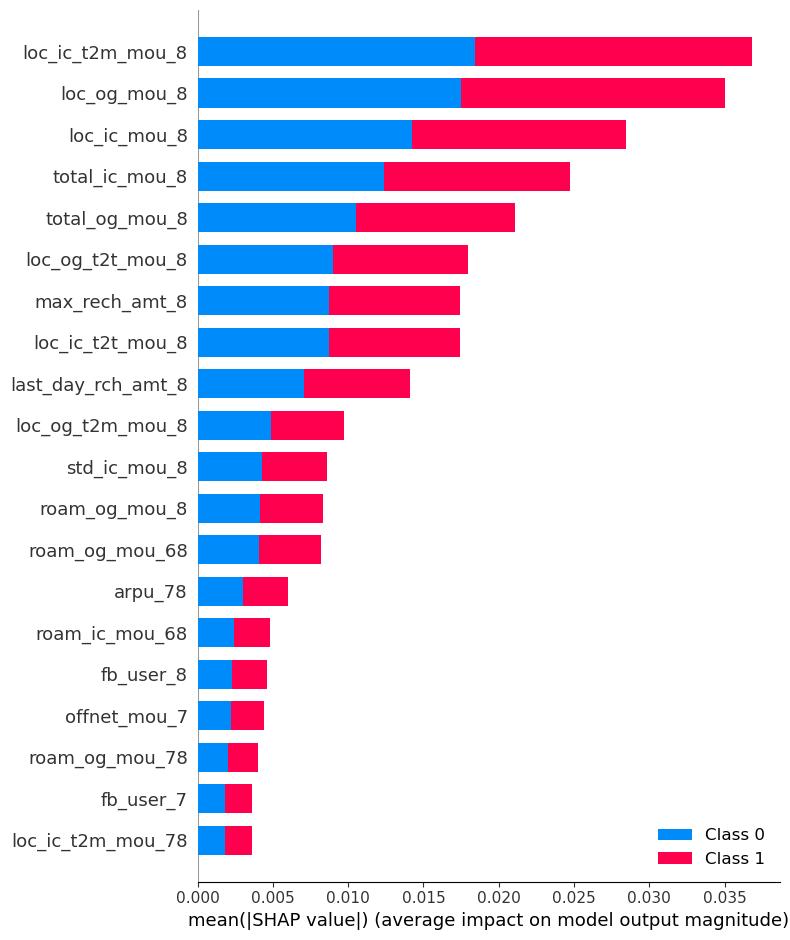

In [25]:
import shap
from matplotlib import pyplot as plt

# Feature Importance with SHAP method
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")